In [2]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime
%matplotlib inline

In [3]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" # <---- Add your API Key
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" # <---- Add your API Secret
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" # <---- Add your access token
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" # <---- Add your access token secret

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["TwitterWrangling"]["twitter_api"]
col.count()

C:\Users\OMEN\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  # This is added back by InteractiveShellApp.init_path()


0

In [33]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=5000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Apple",
            "Samsung",
            "Huawei",
            "Oppo",
            "Vivo",
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Finished
Total Mining Time: 0:08:49.500814
Tweets/Sec: 9.5
Tweets collected: 5000
Total tweets in collection: 5000


C:\Users\OMEN\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere


In [34]:
col.find_one()

{'_id': ObjectId('5f99708a5dc8f5be60301ed3'),
 'created_at': 'Wed Oct 28 13:22:12 +0000 2020',
 'id': 1321442143433564161,
 'id_str': '1321442143433564161',
 'text': '#CallOnMe  https://t.co/tOWMB4bht8',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 72457419,
  'id_str': '72457419',
  'name': 'Bint El Hatshepsut',
  'screen_name': 'aconsciousthot',
  'location': 'Atlanta, GA',
  'url': 'http://www.queensinspirekings.org',
  'description': 'Queens Inspire Kings. Daughter of the FOI. Gentrification Refugee. Sufi Economist & Student of El Salahi. #AfricanInAmerica #Kushite 🇸🇩🇪🇬',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 3831,
  'friends_count': 1623,
  'listed_count': 37,
  'favourites_co

In [35]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset

,created_at,text,user,source,lang
0,Wed Oct 28 13:22:12 +0000 2020,#CallOnMe https://t.co/tOWMB4bht8,@aconsciousthot,"<a href=""http://twitter.com/download/iphone"" r...",und
1,Wed Oct 28 13:22:12 +0000 2020,ALÔ ALÔ CHARLIE NO TUDUM É ISSO MESMO BRASIL?\...,@CharlesGDaily,"<a href=""http://twitter.com/download/android"" ...",pt
2,Wed Oct 28 13:22:13 +0000 2020,RT @Naunaback: Rp 1.400.000 atau $100 atau dig...,@doyyuraakim,"<a href=""http://twitter.com/download/android"" ...",in
3,Wed Oct 28 13:22:13 +0000 2020,#LG Wing With Triple Rear Cameras Launched In ...,@akhiljoseph,"<a href=""https://publer.io"" rel=""nofollow"">Pub...",en
4,Wed Oct 28 13:22:13 +0000 2020,RT @Naunaback: Rp 1.400.000 atau $100 atau dig...,@Taemilkjinie,"<a href=""http://twitter.com/download/android"" ...",in
...,...,...,...,...,...
4995,Wed Oct 28 13:31:01 +0000 2020,"@noticierovv Son igual, o peor que la #Narcoti...",@fjmt1022,"<a href=""https://mobile.twitter.com"" rel=""nofo...",es
4996,Wed Oct 28 13:31:01 +0000 2020,"This would be really great. Granted, it’d prob...",@zatara214,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",en
4997,Wed Oct 28 13:31:02 +0000 2020,"RT @CCI_hdf: 📲Téléchargez #TousAntiCovid, l’ap...",@LegrouxVincent,"<a href=""http://twitter.com/download/iphone"" r...",fr
4998,Wed Oct 28 13:31:02 +0000 2020,vivo en un mundo donde harry nunca me va escri...,@dynastyindie,"<a href=""http://twitter.com/download/iphone"" r...",es


In [36]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,https,2639
1,co,2588
2,rt,2515
3,apple,1316
4,the,1045
5,de,801
6,vivo,752
7,to,743
8,en,550
9,and,506


C:\Users\OMEN\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


twittbot.net             17
                         21
IFTTT                    26
WordPress.com            26
dlvr.it                  35
TweetDeck                45
Twitter for iPad         81
Twitter Web App         757
Twitter for iPhone     1726
Twitter for Android    2029
Name: source, dtype: int64

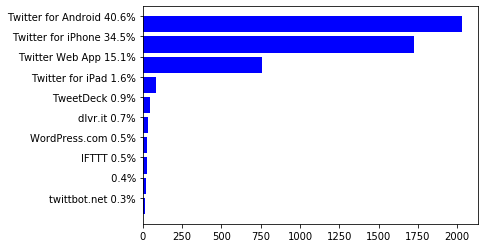

In [37]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

fr       67
it       72
ko       88
th      175
und     330
in      361
ja      407
pt      555
es      745
en     1991
Name: lang, dtype: int64

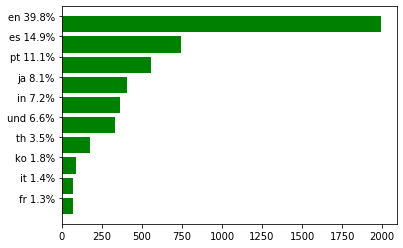

In [38]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [39]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [40]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)
is_dataset1 = dataset1.lang=="en"
dataset1 = dataset1[is_dataset1]
dataset1

,id,text,lang
3,1321442145274863617,#LG Wing With Triple Rear Cameras Launched In ...,en
7,1321442148731027458,"Oh, hey Apple Music update 👋🏾",en
9,1321442149825536001,RT @amazonIN: Take the perfect screenshot and ...,en
11,1321442150702288898,In a way some parents were responsible for the...,en
21,1321442154498166787,RT @WYRevolution: Did you miss the amazing and...,en
...,...,...,...
4980,1321444353953484803,RT @stoolpresidente: Imagine buying any kind o...,en
4986,1321444357115883520,Most of this baby frogs don't really understan...,en
4992,1321444359947096070,Apple tests search: https://t.co/Ku4hrjGxMS,en
4996,1321444362337820673,"This would be really great. Granted, it’d prob...",en


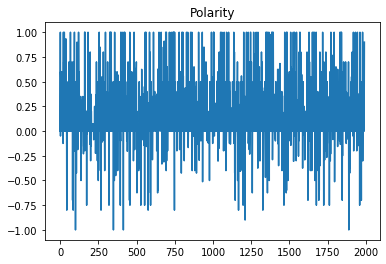

In [41]:
from  textblob import TextBlob
tweettext = dataset1['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in tweettext:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

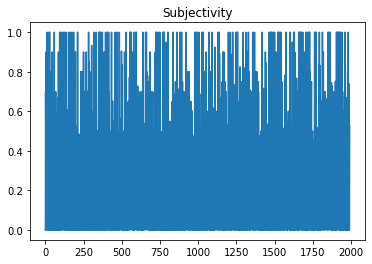

In [42]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [43]:
import statistics
statistics.mean(poltweet.polarity)

0.13232841586859667

In [44]:
statistics.mean(poltweet.subjectivity)

0.3136907828345548

In [45]:
apple_db = dataset1[dataset1['text'].str.contains('Apple')]
samsung_db = dataset1[dataset1['text'].str.contains('Samsung')]
huawei_db = dataset1[dataset1['text'].str.contains('Huawei')]
oppo_db = dataset1[dataset1['text'].str.contains('Oppo')]
vivo_db = dataset1[dataset1['text'].str.contains('Vivo')]

In [46]:
apple_db

,id,text,lang
7,1321442148731027458,"Oh, hey Apple Music update 👋🏾",en
22,1321442154623938561,"RT @billboard_twice: Buy ""I Can't Stop Me"" on ...",en
24,1321442156020727812,Apple Music people: our new album Fantasizer i...,en
33,1321442163385880577,Apple iPhone 12 dormant reverse wireless charg...,en
54,1321442169606078465,RT @ArianaWorldHQ: Apple Music Top 100: Global...,en
...,...,...,...
4963,1321444347275923457,@CatharsisDaily But- Ted Lasso is the best sho...,en
4978,1321444353236103168,RT @CrabPremiums: 🦀 SELLING AFFORDABLE PREMIUM...,en
4992,1321444359947096070,Apple tests search: https://t.co/Ku4hrjGxMS,en
4996,1321444362337820673,"This would be really great. Granted, it’d prob...",en


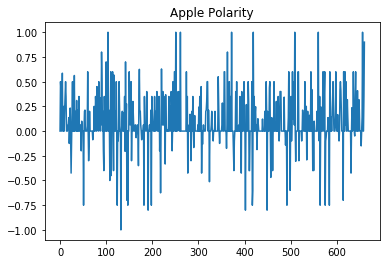

In [47]:
apple_text = apple_db['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in apple_text:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

apple_pol = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
apple_pol.polarity.plot(title='Apple Polarity')
plt.show()

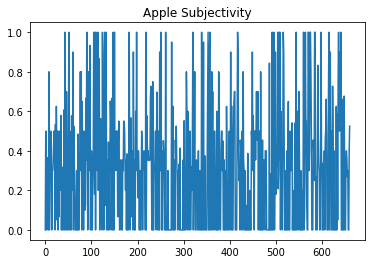

In [48]:
apple_pol.subjectivity.plot(title='Apple Subjectivity')
plt.show()

In [49]:
statistics.mean(apple_pol.polarity)

0.08266432720148681

In [50]:
statistics.mean(apple_pol.subjectivity)

0.3074390323633894

In [51]:
samsung_db

,id,text,lang
36,1321442164509937671,RT @Namaze5: Am selling Samsung S8 used for 1y...,en
88,1321442180339294210,@banglanews24com Samsung Galaxy J2 Google Acco...,en
114,1321442194209853442,The value of @Samsung phones can be told in mo...,en
196,1321442235854958595,RT @Jhopesfashion: Hoseok's Denim jacket Map o...,en
205,1321442240762310657,$LIN: Linde plc signs second long-term agreeme...,en
...,...,...,...
4688,1321444222407331840,Samsung giveaway,en
4795,1321444267789746177,@Joon_1306_07er @BTS_twt 3. Samsung\n\nI'm vot...,en
4846,1321444290426474497,"RT @PS5only: ""Best TV for PS5 Gaming 2020""\n\n...",en
4935,1321444333489397760,Samsung really thought that we forgot that the...,en


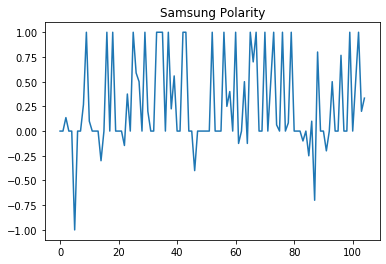

In [52]:
samsung_text = samsung_db['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in samsung_text:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

samsung_pol = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
samsung_pol.polarity.plot(title='Samsung Polarity')
plt.show()

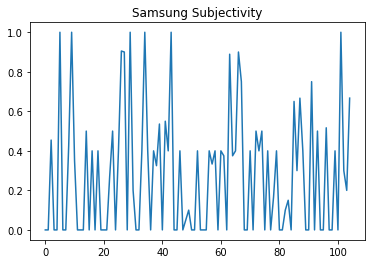

In [53]:
samsung_pol.subjectivity.plot(title='Samsung Subjectivity')
plt.show()

In [54]:
statistics.mean(samsung_pol.polarity)

0.26000870954442384

In [55]:
statistics.mean(samsung_pol.subjectivity)

0.27864052085480656

In [56]:
huawei_db

,id,text,lang
64,1321442172080517126,@ShopeeID A pliss minn\n\nA Huawei P40 pro+\...,en
116,1321442195505774593,@ShopeeID A pliss minn\n\nA Huawei P40 pro+\...,en
166,1321442219744587776,@ShopeeID A pliss minn\n\nA Huawei P40 pro+\...,en
182,1321442228217147393,BT and Ericsson sign 5G deal as Huawei ban tak...,en
191,1321442232839376896,RT @HuaweiCarrier: Follow Huawei Carrier Busin...,en
...,...,...,...
4090,1321443947928059906,"At the beginning of the new decade, the changi...",en
4144,1321443972321980416,@Stormtrooper184 @TheGalox_ That's what I mean...,en
4153,1321443976029868032,RT @ThedailyNG: How Huawei is accelerating dig...,en
4648,1321444201570226178,Huawei AM12 Plus in-Ear Headphone (Grey)@ Rs. ...,en


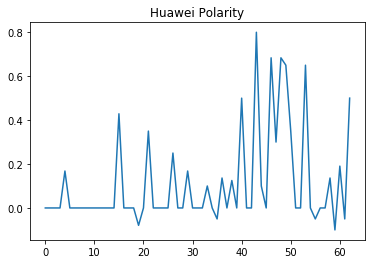

In [57]:
huawei_text = huawei_db['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in huawei_text:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

huawei_pol = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
huawei_pol.polarity.plot(title='Huawei Polarity')
plt.show()

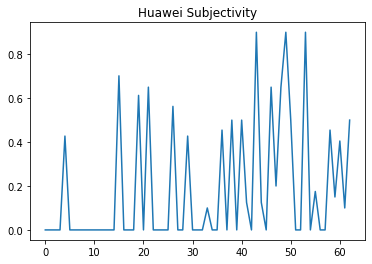

In [58]:
huawei_pol.subjectivity.plot(title='Huawei Subjectivity')
plt.show()

In [59]:
statistics.mean(huawei_pol.polarity)

0.11018056843949701

In [60]:
statistics.mean(huawei_pol.subjectivity)

0.18523672095100666

In [61]:
oppo_db

,id,text,lang
9,1321442149825536001,RT @amazonIN: Take the perfect screenshot and ...,en
87,1321442179433123842,@amazonIN Got my screenshot of OPPO A15 PERFEC...,en
112,1321442192595030018,@amazonIN Here's my perfect screenshot of Oppo...,en
155,1321442214279524355,Hands-on: Oppo A15 Review https://t.co/PRmC4HC5bc,en
185,1321442230280712195,RT @amazonIN: Take the perfect screenshot and ...,en
...,...,...,...
4491,1321444133358178309,The perfect screenshot of Oppo A15. #AmazonSpe...,en
4619,1321444187276005376,RT @amazonIN: Take the perfect screenshot and ...,en
4818,1321444278757810177,@amazonIN Here's my perfect screen shot of OPP...,en
4886,1321444308998705152,RT @amazonIN: Take the perfect screenshot and ...,en


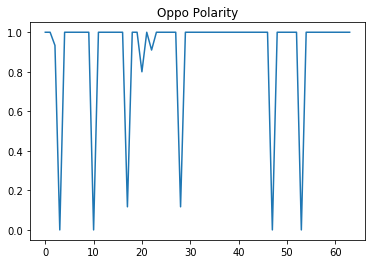

In [62]:
oppo_text = oppo_db['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in oppo_text:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

oppo_pol = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
oppo_pol.polarity.plot(title='Oppo Polarity')
plt.show()

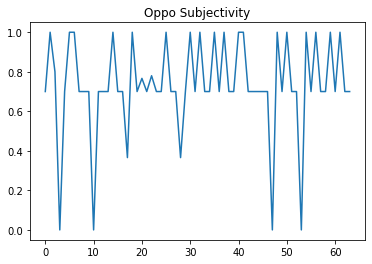

In [63]:
oppo_pol.subjectivity.plot(title='Oppo Subjectivity')
plt.show()

In [64]:
statistics.mean(oppo_pol.polarity)

0.9043296807359308

In [65]:
statistics.mean(oppo_pol.subjectivity)

0.7340354437229437

In [66]:
vivo_db

,id,text,lang
142,1321442209510629377,Vivo V20 SE surfaces on Croma and Reliance Dig...,en
1148,1321442646661996544,"Vivo V20 SE likely to be priced at Rs 20,990 i...",en
1968,1321443015341281283,"Vivo V20 SE likely to be priced at Rs 20,990 i...",en
3367,1321443633699020800,RT @Vivo_Phil: Watch how LANY stays in focus w...,en
3767,1321443809146724355,RT @Vivo_Phil: Watch how LANY stays in focus w...,en


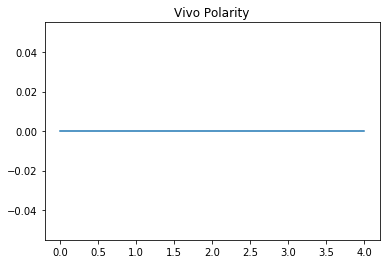

In [67]:
from  textblob import TextBlob
vivo_text = vivo_db['text']
wordlist = pd.DataFrame();

polarity = []
subj = []

for t in vivo_text:
    tx = TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

vivo_pol = pd.DataFrame({'polarity':polarity,'subjectivity':subj})
vivo_pol.polarity.plot(title='Vivo Polarity')
plt.show()

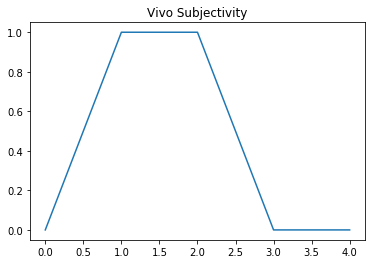

In [68]:
vivo_pol.subjectivity.plot(title='Vivo Subjectivity')
plt.show()

In [69]:
statistics.mean(vivo_pol.polarity)

0.0

In [70]:
statistics.mean(vivo_pol.subjectivity)

0.4